In [68]:
#Импорт библиотек

import csv
import pandas as pd
import numpy as np
import math
import scipy.stats as st
import itertools as it
import numpy.matlib as nm
from sklearn import metrics
import sklearn.model_selection as ms
import sklearn.metrics as metrics
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn import linear_model
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn.tree as tree
import pydotplus
from IPython.display import Image
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
import random
%matplotlib inline
from scipy import stats

In [69]:
#Расчет Somers D

def somers_d(xx,yy,weight = None):
    
    '''
    xx - feature
    yy - target
    weight - weights
    '''
    
    if weight is None: weight = np.ones(len(xx))

    x = st.rankdata(xx)
    y = st.rankdata(yy)
    weight = np.array(weight)
    
    n2_const = sum(weight[:-1]*(sum(weight)-np.cumsum(weight[:-1])))
    K, y_adj = 0, 0

    for i in range(len(weight)-1):
        sign_arr_x = np.sign(x[i]-x[i+1:len(weight)])
        sign_arr_y = np.sign(y[i]-y[i+1:len(weight)])
        ww_arr = weight[i]*weight[i+1:]

        K += sum(ww_arr*sign_arr_x*sign_arr_y)
        y_adj += sum(ww_arr*(1 - abs(sign_arr_y*sign_arr_y)))
        
    return K/(n2_const-y_adj)

In [70]:
a = pd.read_excel(io='Data_LGD_home.xlsx',sheet_name='LGD_dataset');
a.head()

,ID,INN,DNW,LGD_target,D_last date,DNW_D,Fact_spis,x1,x2,x3,...,x6,x7,x8,x9,x10,x11,x12,x13,x14,Bootstrap
0,1,1006004155,1,0.0,0,748062,0,9322584,-281640,6528167,...,0.271262,0.194722,-0.528777,0.700253,0.386323,0.725605,11,1,0,1
1,2,1101061763,1,1.0,74655,18333,1,692498,18371,3345219,...,0.813498,0.593327,-0.138757,4.830655,0.376312,0.743998,14,1,0,2
2,4,1216012466,1,1.0,148912,55442,1,790750,3039,1593880,...,1.101191,0.617063,0.086615,2.015656,0.053444,0.855961,11,0,0,1
3,10,1435090883,1,0.0,0,24060,0,592232,-9205,1255417,...,1.897815,0.715997,0.454641,2.119806,0.024590,0.506386,13,1,0,2
4,11,1646022089,1,0.0,0,715948,0,2163905,-359490,2762999,...,0.734451,0.125916,-0.307985,1.276858,0.029794,1.159806,3,3,0,2


In [71]:
#Результаты однофакторного анализа для целевой переменной LGD_target ()
SF_analysis_LGD_target = np.array([-somers_d(a.x1,a.LGD_target,weight = None),-somers_d(a.x2,a.LGD_target,weight = None),
-somers_d(a.x3,a.LGD_target,weight = None),somers_d(a.x4,a.LGD_target,weight = None),-somers_d(a.x5,a.LGD_target,weight = None),
-somers_d(a.x6,a.LGD_target,weight = None),-somers_d(a.x7,a.LGD_target,weight = None),-somers_d(a.x8,a.LGD_target,weight = None),
-somers_d(a.x9,a.LGD_target,weight = None),-somers_d(a.x10,a.LGD_target,weight = None),somers_d(a.x11,a.LGD_target,weight = None),
-somers_d(a.x12,a.LGD_target,weight = None),-somers_d(a.x13,a.LGD_target,weight = None),-somers_d(a.x14,a.LGD_target,weight = None)]);
print(SF_analysis_LGD_target);

[-0.02108815 -0.10501898  0.06242092  0.00548292 -0.0763391   0.0033741
  0.02108815 -0.02867988  0.01687052  0.11345424  0.06452973 -0.02804724
 -0.02910164 -0.04238718]


In [ ]:
#Вывод - модели регрессии не подходят для разработки из-за малости Somers'D по большинству риск-факторов, поэтому требуются модели деревянной структуры

In [73]:
#Кросс-валидация модели LGD для дерева регрессии (для определения перечня переменных, работающих стабильнее всего, с целью исключения переобучения модели)
#Исключаются переменные с отрицательным значением коэффициента Джини с переменной LGD_target, так как они вносят нестабильность в модели

max_int = 11;
cv_scores = [];

for i in range (1, max_int):
    d_tree = tree.DecisionTreeRegressor(max_depth = i, min_samples_leaf = 12, min_impurity_decrease = 0.000001)
    scores = cross_val_score(d_tree,pd.DataFrame(np.array([a.x3,a.x4,a.x6,a.x7,a.x9,a.x10,a.x11]).transpose()),a.LGD_target, cv = 4, scoring = 'r2')
    cv_scores.append(scores.mean())
    
print("Значения коэффициента r2 на кросс-валидации для решающего дерева =",cv_scores);

Значения коэффициента r2 на кросс-валидации для решающего дерева = [-0.16396917280955076, -0.2653951075351631, -0.4002839801528128, -0.4074113730622013, -0.3973382983329648, -0.3973382983329648, -0.3973382983329648, -0.3973382983329648, -0.3973382983329648, -0.3973382983329648]


In [200]:
#Разработка модели LGD на основе дерева регрессии - формирование первичных данных для разработки (для исключения переобучения убираем факторы с отрицательным Джини для модели Исходов и оставляем переменные, наиболее точно работающие на кросс-валидации)

rsh = pd.DataFrame(np.array([a.x3,a.x4,a.x6,a.x7,a.x9,a.x10,a.x11]).transpose());
print(rsh);

             0          1         2         3         4         5         6
0    6528167.0  9116927.0  0.271262  0.194722  0.700253  0.386323  0.725605
1    3345219.0   522437.0  0.813498  0.593327  4.830655  0.376312  0.743998
2    1593880.0   781633.0  1.101191  0.617063  2.015656  0.053444  0.855961
3    1255417.0   603552.0  1.897815  0.715997  2.119806  0.024590  0.506386
4    2762999.0  2509711.0  0.734451  0.125916  1.276858  0.029794  1.159806
..         ...        ...       ...       ...       ...       ...       ...
131  1266060.0   843382.0  0.752016  0.224346  1.369700  0.277769  0.886802
132  8025028.0  7785423.0  1.511631  0.917868  0.999548  0.277444  0.275023
133  4184605.0  4601282.0  0.738553  0.637169  0.852526  0.322493  0.902127
134  1031381.0  7034989.0  0.433356  0.269649  0.146110  0.741103  0.194558
135  4995424.0  3150976.0  0.353159  0.283866  1.236278  0.711680  0.740945

[136 rows x 7 columns]


In [201]:
#Настройка дерева регрессии с глубиной 10, ее достаточно, так как наиболее точное дерево обычно имеет глубину меньше

clf = tree.DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 16, min_impurity_decrease = 0.000001);
clf_fit = clf.fit(rsh,a.LGD_target);
clf_fit_score = clf_fit.score(rsh,a.LGD_target)

In [203]:
#R2 полученной модели
clf_fit_score

0.1400420788001312

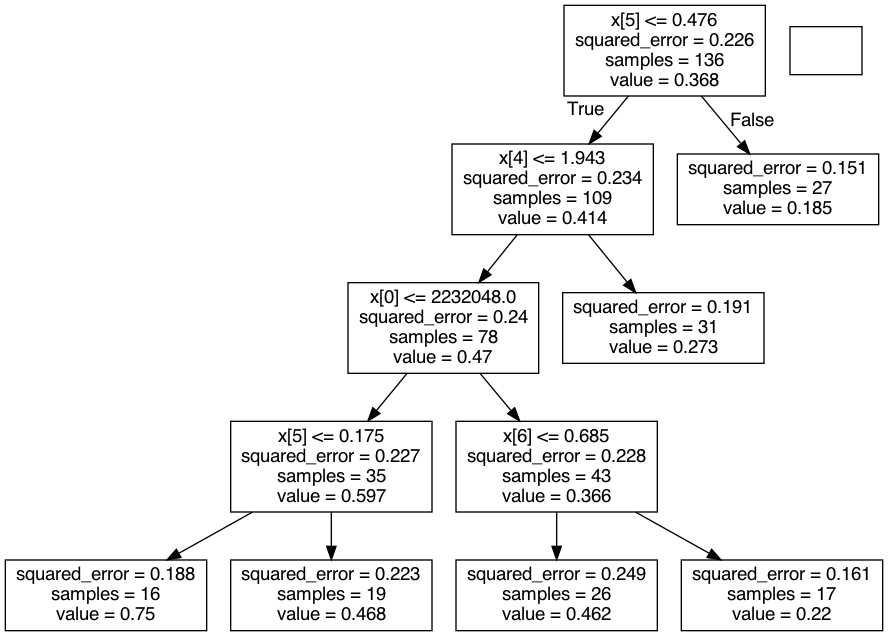

In [204]:
#Графическая визуализация дерева
dot_data = tree.export_graphviz(clf,out_file=None);
graph = pydotplus.graph_from_dot_data(dot_data);
Image(graph.create_png())

In [ ]:
#x[6] (a.x11) работает в дереве неинтерпретируемо. Для большего соотношения собственного к заемному капиталу имеем LGD=22%, а для меньшего соотношения LGD=46,2%, хотя по экономической логике, чем меньше соотношение, тем LGD должен быть ниже. Тут имеем противоречие. Поэтому переменная эта и уходит из анализа

In [78]:
#Формирование итогового варианта дерева регрессии
#rsh = pd.DataFrame(np.array([a.x1,a.x2,a.x3,a.x4,a.x5,a.x6,a.x7,a.x8,a.x9,a.x10,a.x11,a.x12,a.x13,a.x14]).transpose());
rsh = pd.DataFrame(np.array([a.x3,a.x4,a.x6,a.x7,a.x9,a.x10]).transpose());
print(rsh);

             0          1         2         3         4         5
0    6528167.0  9116927.0  0.271262  0.194722  0.700253  0.386323
1    3345219.0   522437.0  0.813498  0.593327  4.830655  0.376312
2    1593880.0   781633.0  1.101191  0.617063  2.015656  0.053444
3    1255417.0   603552.0  1.897815  0.715997  2.119806  0.024590
4    2762999.0  2509711.0  0.734451  0.125916  1.276858  0.029794
..         ...        ...       ...       ...       ...       ...
131  1266060.0   843382.0  0.752016  0.224346  1.369700  0.277769
132  8025028.0  7785423.0  1.511631  0.917868  0.999548  0.277444
133  4184605.0  4601282.0  0.738553  0.637169  0.852526  0.322493
134  1031381.0  7034989.0  0.433356  0.269649  0.146110  0.741103
135  4995424.0  3150976.0  0.353159  0.283866  1.236278  0.711680

[136 rows x 6 columns]


In [79]:
#Настройка дерева регрессии с глубиной 10, ее достаточно, так как наиболее точное дерево обычно имеет глубину меньше
clf = tree.DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 16, min_impurity_decrease = 0.000001);
clf_fit = clf.fit(rsh,a.LGD_target);
clf_fit_score = clf_fit.score(rsh,a.LGD_target)

In [80]:
#R2 полученной модели
clf_fit_score

0.13559482949100465

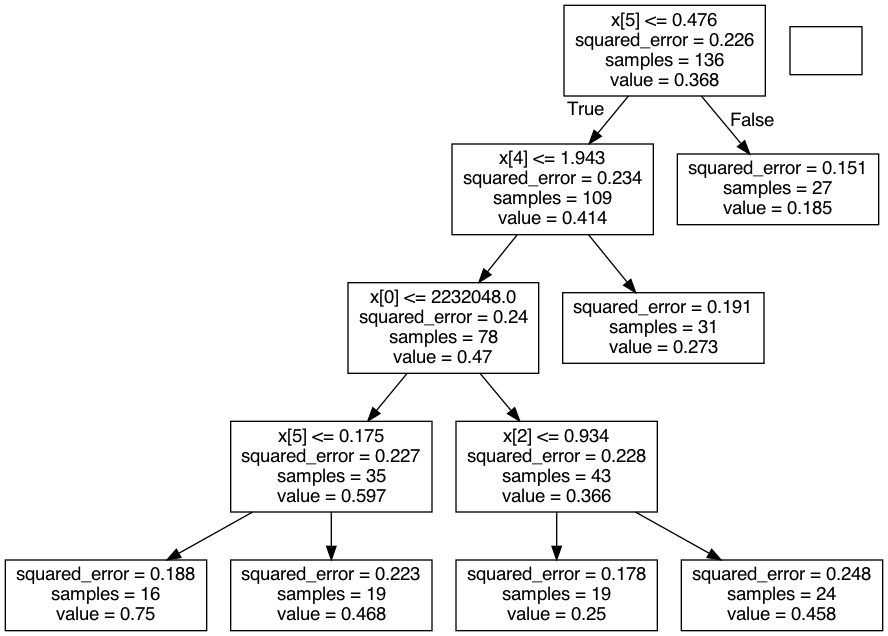

In [81]:
#Графическая визуализация дерева
dot_data = tree.export_graphviz(clf,out_file=None);
graph = pydotplus.graph_from_dot_data(dot_data);
Image(graph.create_png())

In [62]:
#Значение порога переменной x6 "Оборотные активы/Краткосрочные обязательства", выше которого переменная разбивается неинтерпретируемо 
clf_fit.tree_.threshold[6]
# не включаем x6 в модель

0.9343961775302887

In [205]:
#Формирование итогового варианта дерева регрессии
rsh = pd.DataFrame(np.array([a.x3,a.x4,a.x7,a.x9,a.x10]).transpose());
print(rsh);

             0          1         2         3         4
0    6528167.0  9116927.0  0.194722  0.700253  0.386323
1    3345219.0   522437.0  0.593327  4.830655  0.376312
2    1593880.0   781633.0  0.617063  2.015656  0.053444
3    1255417.0   603552.0  0.715997  2.119806  0.024590
4    2762999.0  2509711.0  0.125916  1.276858  0.029794
..         ...        ...       ...       ...       ...
131  1266060.0   843382.0  0.224346  1.369700  0.277769
132  8025028.0  7785423.0  0.917868  0.999548  0.277444
133  4184605.0  4601282.0  0.637169  0.852526  0.322493
134  1031381.0  7034989.0  0.269649  0.146110  0.741103
135  4995424.0  3150976.0  0.283866  1.236278  0.711680

[136 rows x 5 columns]


In [206]:
#Настройка дерева регрессии с глубиной 10, ее достаточно, так как наиболее точное дерево обычно имеет глубину меньше
clf = tree.DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 16, min_impurity_decrease = 0.003);
clf_fit = clf.fit(rsh,a.LGD_target);
clf_fit_score = clf_fit.score(rsh,a.LGD_target)

In [207]:
#R2 полученной модели
clf_fit_score

0.12059683458171522

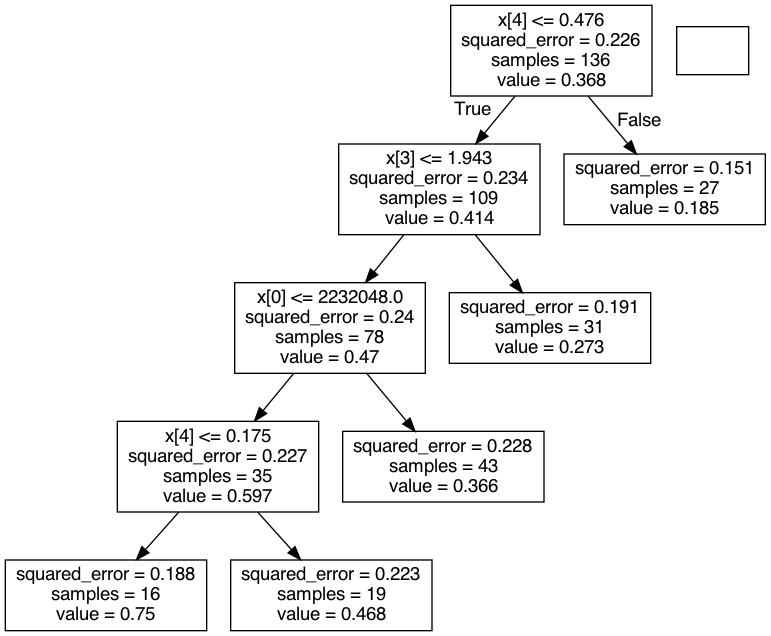

In [208]:
#Графическая визуализация дерева
dot_data = tree.export_graphviz(clf,out_file=None);
graph = pydotplus.graph_from_dot_data(dot_data);
Image(graph.create_png())

In [209]:
#Вывод статистик Somers'D и r2 итоговой модели до кросс-валидации
print("Somers'D модели =", somers_d(pd.DataFrame(clf_fit.predict(rsh)),a.LGD_target,weight = None));
print("r2 модели =", clf_fit_score);

Somers'D модели = 0.3696752425137073
r2 модели = 0.12059683458171522


In [210]:
#Кросс-валидация модели LGD для дерева регрессии (для определения оптимальной итоговой глубины дерева с целью исключения переобучения модели)

max_int = 11;
cv_scores = [];

for i in range (1, max_int):
    d_tree = tree.DecisionTreeRegressor(max_depth = i, min_samples_leaf = 14, min_impurity_decrease = 0.000001)
    scores = cross_val_score(d_tree,pd.DataFrame(np.array([a.x3,a.x4,a.x7,a.x9,a.x10]).transpose()),a.LGD_target, cv = 4, scoring = 'r2')
    cv_scores.append(scores.mean())
    
print("Значения коэффициента r2 на кросс-валидации для решающего дерева =",cv_scores);
#Оптимальная глубина = 3 или 4 (необходимо дополнительно провести кросс-валидацию без учета переменных, входящих в модель на глубинах 4 и выше)

Значения коэффициента r2 на кросс-валидации для решающего дерева = [-0.20115776838670307, -0.20396793573069083, -0.2813234536449941, -0.28098944584300733, -0.28098944584300733, -0.28098944584300733, -0.28098944584300733, -0.28098944584300733, -0.28098944584300733, -0.28098944584300733]


In [212]:
#Кросс-валидация модели LGD для дерева регрессии с переменными, входящими в наилучшее дерево глубины 3

max_int = 11;
cv_scores = [];

for i in range (1, max_int):
    d_tree = tree.DecisionTreeRegressor(max_depth = i, min_samples_leaf = 14, min_impurity_decrease = 0.000001)
    scores = cross_val_score(d_tree,pd.DataFrame(np.array([a.x3,a.x9,a.x10]).transpose()),a.LGD_target, cv = 4, scoring = 'r2')
    cv_scores.append(scores.mean())
    
print("Значения коэффициента r2 на кросс-валидации для решающего дерева =",cv_scores);

Значения коэффициента r2 на кросс-валидации для решающего дерева = [-0.20115776838670307, -0.20396793573069072, -0.2398552610139948, -0.26833302808475445, -0.26833302808475445, -0.26833302808475445, -0.26833302808475445, -0.26833302808475445, -0.26833302808475445, -0.26833302808475445]


In [214]:
#Оптимальное значение коэффициента r2 на кросс-валидации (просадка модели относительно глубин 1 и 2 на кросс-валидации незначительна (менее 7%), поэтому можно выбрать глубину 4)
best = 4
print("Оптимальная глубина дерева =", best)

Оптимальная глубина дерева = 4


In [226]:
#Формирование итогового варианта дерева регрессии
rsh = pd.DataFrame(np.array([a.x3,a.x9,a.x10]).transpose());
print(rsh);

             0         1         2
0    6528167.0  0.700253  0.386323
1    3345219.0  4.830655  0.376312
2    1593880.0  2.015656  0.053444
3    1255417.0  2.119806  0.024590
4    2762999.0  1.276858  0.029794
..         ...       ...       ...
131  1266060.0  1.369700  0.277769
132  8025028.0  0.999548  0.277444
133  4184605.0  0.852526  0.322493
134  1031381.0  0.146110  0.741103
135  4995424.0  1.236278  0.711680

[136 rows x 3 columns]


In [227]:
#Вывод итогового дерева для модели LGD на основе дерева регрессии с оптимальной глубиной = 4 на кросс-валидации
clf = tree.DecisionTreeRegressor(max_depth = 4, min_samples_leaf = 16, min_impurity_decrease = 0.003);
clf_fit = clf.fit(rsh,a.LGD_target);
clf_fit_score = clf_fit.score(rsh,a.LGD_target)

In [228]:
#R2 полученной модели
clf_fit_score

0.12059683458171522

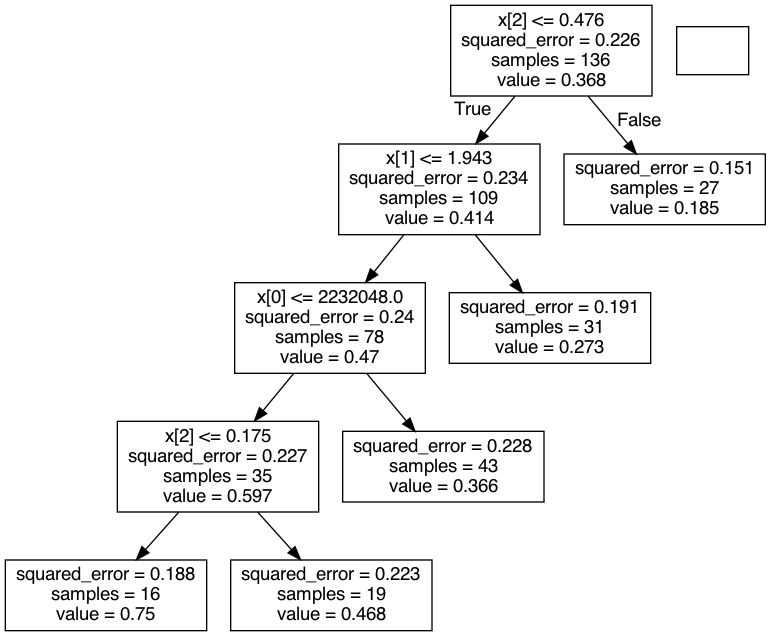

In [229]:
#Графическая визуализация дерева
dot_data = tree.export_graphviz(clf,out_file=None);
graph = pydotplus.graph_from_dot_data(dot_data);
Image(graph.create_png())

In [230]:
#Вывод статистик Somers'D и r2 итоговой модели с учетом кросс-валидации
print("Somers'D модели =", somers_d(pd.DataFrame(clf_fit.predict(rsh)),a.LGD_target,weight = None));
print("r2 модели =", clf_fit_score);

Somers'D модели = 0.3696752425137073
r2 модели = 0.12059683458171522


In [231]:
#Loss Shortfall test
print("Значение статистики для Loss Shortfall test =", 1 - (sum(clf_fit.predict(rsh)*np.array(a.DNW_D))/sum(a.LGD_target*np.array(a.DNW_D))));
#MAD test
print("Значение статистики для MAD test =", sum(abs(a.LGD_target - clf_fit.predict(rsh))*np.array(a.DNW_D))/sum(np.array(a.DNW_D)));

Значение статистики для Loss Shortfall test = -0.649711563313977
Значение статистики для MAD test = 0.36080884835628463


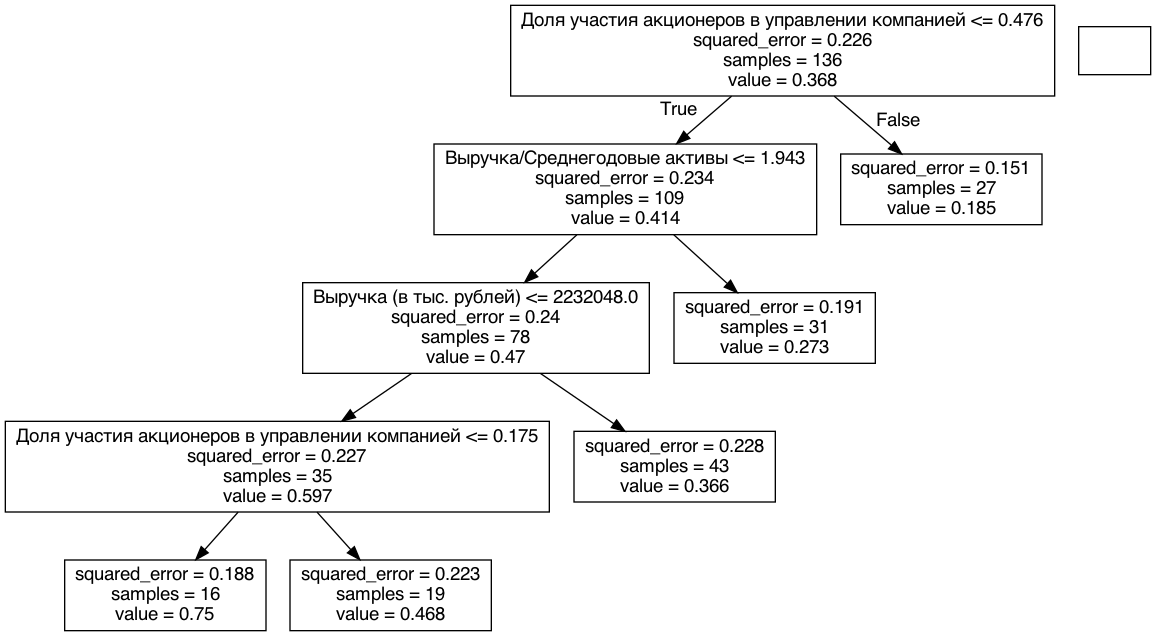

In [248]:
#Итоговое дерево модели LGD

dot_data = tree.export_graphviz(clf,out_file=None,feature_names=['Выручка (в тыс. рублей)','Выручка/Среднегодовые активы','Доля участия акционеров в управлении компанией']);
graph = pydotplus.graph_from_dot_data(dot_data);
Image(graph.create_png())

In [250]:
#Формирование бутстрапов для тестирования финальной модели
sd_b_1_0 = pd.DataFrame(np.array([a.Bootstrap,clf_fit.predict(rsh),a.LGD_target]).transpose());
sd_b_1 = sd_b_1_0[sd_b_1_0[0] == 1]
sd_b_2_0 = pd.DataFrame(np.array([a.Bootstrap,clf_fit.predict(rsh),a.LGD_target]).transpose());
sd_b_2 = sd_b_2_0[sd_b_2_0[0] == 2]
sd_b_3_0 = pd.DataFrame(np.array([a.Bootstrap,clf_fit.predict(rsh),a.LGD_target]).transpose());
sd_b_3 = sd_b_3_0[sd_b_3_0[0] == 3]
sd_b_4_0 = pd.DataFrame(np.array([a.Bootstrap,clf_fit.predict(rsh),a.LGD_target]).transpose());
sd_b_4 = sd_b_4_0[sd_b_4_0[0] == 4]

In [251]:
#Характеристики итоговой модели LGD
print("Количество наблюдений в исходной выборке =", a.x1.shape[0]);
print("Значимость весов риск-факторов в модели =",clf_fit.feature_importances_);
print("Значение коэффициента Somers'D модели =", somers_d(pd.DataFrame(clf_fit.predict(rsh)),a.LGD_target,weight = None));
print("Среднее значение коэффициента Somers'D модели на бутстрапах =",np.mean([somers_d(sd_b_1[1],sd_b_1[2],weight = None),somers_d(sd_b_2[1],sd_b_2[2],weight = None),somers_d(sd_b_3[1],sd_b_3[2],weight = None),somers_d(sd_b_4[1],sd_b_4[2],weight = None)]));
print("Значение коэффициента корреляции Спирмена модели =", stats.spearmanr(pd.DataFrame(clf_fit.predict(rsh)),a.LGD_target)[0]);
print("Среднее значение коэффициента Спирмена модели на бутстрапах =",np.mean([stats.spearmanr(sd_b_1[1],sd_b_1[2])[0],stats.spearmanr(sd_b_2[1],sd_b_2[2])[0],stats.spearmanr(sd_b_3[1],sd_b_3[2])[0],stats.spearmanr(sd_b_4[1],sd_b_4[2])[0]]));
print("Значение коэффициента r2 модели =", clf_fit_score);
print("Значение коэффициента r2 на кросс-валидации =",cv_scores[2]);
print("Среднее значение коэффициента r2 модели на бутстрапах =",np.mean([metrics.r2_score(sd_b_1[2], sd_b_1[1]),metrics.r2_score(sd_b_2[2], sd_b_2[1]),metrics.r2_score(sd_b_3[2], sd_b_3[1]),metrics.r2_score(sd_b_4[2], sd_b_4[1])]));
print("Значение статистики для Loss Shortfall test =", 1 - (sum(clf_fit.predict(rsh)*np.array(a.DNW_D))/sum(a.LGD_target*np.array(a.DNW_D))));
print("Значение статистики для MAD test =", sum(abs(a.LGD_target - clf_fit.predict(rsh))*np.array(a.DNW_D))/sum(np.array(a.DNW_D)));

Количество наблюдений в исходной выборке = 136
Значимость весов риск-факторов в модели = [0.27714487 0.23078178 0.49207335]
Значение коэффициента Somers'D модели = 0.3696752425137073
Среднее значение коэффициента Somers'D модели на бутстрапах = 0.3532494694858441
Значение коэффициента корреляции Спирмена модели = 0.33953433934861477
Среднее значение коэффициента Спирмена модели на бутстрапах = 0.3135742142720701
Значение коэффициента r2 модели = 0.12059683458171522
Значение коэффициента r2 на кросс-валидации = -0.2398552610139948
Среднее значение коэффициента r2 модели на бутстрапах = 0.054359139069848156
Значение статистики для Loss Shortfall test = -0.649711563313977
Значение статистики для MAD test = 0.36080884835628463
